In [1]:
import numpy as np 
import pandas as pd 
import os
import re
import statsmodels.api as sm

import itertools
import matplotlib.pyplot as plt
import matplotlib
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import glob
from scipy import stats

currdir = os.getcwd()
parent = os.path.dirname(currdir)
gparent = os.path.dirname(parent)

In [2]:
def custom_sort(item):
    if item.endswith('basal'):
        return 0  
    else:
        return int(item.split('uM')[0].split('_')[-1])
def ensure_dirs_exists(path):
    directory = os.path.dirname(path)  # Get the directory part of the file path
    if not os.path.exists(directory):
        os.makedirs(directory)
    return

In [3]:
## read in data, div19_26uMbicucilin, 19_basal
lines_to_skip = 10 # adjust 

# count the number of header lines
EXPERIMENT_TIME = "1_MIN"
plate_type = 'DIV19' #adjust

PERTURBATION = "CNO" # adjust
firstTableHeading = "Number of Spikes"
## conditions taken: ### we will define this as dose1,dose2, dose3, dose4, each incrementing in terms of doses

FOLDER_PATH = f"{parent}/data/Div19_Bicucilin/" #
folder_dict = {}
balances= {"basal": "",
        "dose1": "",
        "dose2": "",
        "dose3": "",
        "dose4": ""
        }

## WALK Through folder of interest
for dirpath, dirnames, filenames in os.walk(FOLDER_PATH):
    if dirpath != FOLDER_PATH:
        folder_dict[dirpath.split("/")[-1]] = dirpath
    elif not dirnames:
        folder_dict['basal'] = dirpath

## get doses names in increasing order 
dose_names = [name for name in folder_dict.keys() if 'basal' not in name]
dose_names.sort(key=custom_sort)

# Initialize balances dictionaryd
balances = {"basal": "basal"}

## map sorted doses
for i, dose_name in enumerate(dose_names, start=1):
    balances[f"dose{i}"] = dose_name.split("_")[-1]

print("Balances:", balances)


Balances: {'basal': 'basal', 'dose1': '2uMbicucilin', 'dose2': '6uMbicucilin', 'dose3': '26uMbicucilin'}


In [4]:
## now only select the control and maximum
last = list(balances.keys())[-1]
balances = {k: balances[k] for k in ('basal', f'{last}')}
getnums_f = lambda x: [int(num) for num in re.findall(r'\d+', x.split("_")[-1])]
concnums = list(map(getnums_f, list(folder_dict.keys())))
concnums = list(itertools.chain(*concnums))
folder_dict = {k: folder_dict[k] for k in folder_dict.keys() if any(x in k for x in ('basal', str(max(concnums))))}
folder_dict, balances

({'Div19_26uMbicucilin': '/home/poojaparameswaran/Documents/SoderlingLab/MicroElectrodeArrayAnalysis/data/Div19_Bicucilin/Div19_26uMbicucilin',
  'Div19_basal': '/home/poojaparameswaran/Documents/SoderlingLab/MicroElectrodeArrayAnalysis/data/Div19_Bicucilin/Div19_basal'},
 {'basal': 'basal', 'dose3': '26uMbicucilin'})

In [5]:
def read_csvs_to_dict(folder, lines_to_skip=10):
    files = glob.glob(os.path.join(folder, "*.csv"))
    data_dict = {}
    for file in files:
        # Extracting the plate number from the filename
        cond = (file.split("/")[-2].split("_")[-1])
        plate_num = re.search(r'plate\s?(\d+)', file, re.IGNORECASE)
        if plate_num:
            plate_key = f"plate_{plate_num.group(1)}"
            df = pd.read_csv(file, skiprows = lines_to_skip)
            df = df.drop(columns=['Unnamed: 9'])
            df['Subject'] = plate_key
            data_dict[plate_key] = df
    return data_dict
all_files_dict = {}

for dose, folder in folder_dict.items():
    all_files_dict[dose] = read_csvs_to_dict(folder)
for dose, files_dict in all_files_dict.items():
    print(files_dict.keys())

dict_keys(['plate_1', 'plate_2', 'plate_3'])
dict_keys(['plate_2', 'plate_3', 'plate_1'])


In [6]:
def concat_plates(plates_dict, firstHeading):
    experiment = {}
    testparams_concat = {}
    for plate, df in plates_dict.items():
        maxrows = df.shape[0]
        vals_between_tables = 16
        titles = [heading_ind for heading_ind in range(14, maxrows+16, 16)]
        titles.insert(0,0)
        # # Empty dictionary to store dataframes
        # Loop through start indices
        for ind in range(len(titles) -1):
            if ind == 0:
                ## Handle mean firing rate
                key = firstHeading
                table = df.iloc[titles[ind] : titles[ind +1], :]
                # table = rename_row_names(table)
            elif ind != 0:
                table = df.iloc[titles[ind] : titles[ind +1], :]
                key = table.iloc[0][0] # just get name
                table = df.iloc[titles[ind] +2: titles[ind +1], :]

            table.set_index('Unnamed: 0', inplace=True)
            if key not in experiment:
                experiment[key] = []
            experiment[key].append(table)
    
    for testparam, df_list in experiment.items():
        concated_table = pd.concat(df_list, ignore_index=False)
        testparams_concat[testparam] = concated_table
    
    testparams_concat = {key.strip(): value for key, value in testparams_concat.items()}
    return testparams_concat
doses = {}
for dose, plates in all_files_dict.items():
    doses[dose] = concat_plates(plates, firstTableHeading)

doses.keys()

dict_keys(['Div19_26uMbicucilin', 'Div19_basal'])

In [7]:
def remove_mean_SEM(test_dict, chemical_type):
    for key, value in test_dict.items():
        to_drop = [index for index in ['B Mean', 'B SEM'] if index in value.index]
        if to_drop:
            test_dict[key] = value.drop(index=to_drop)
        test_dict[key]['Chemical_Type']=chemical_type
    return test_dict
for dose, parameter_dict in doses.items():
    doses[dose] = remove_mean_SEM(parameter_dict, dose)

doses.keys()

dict_keys(['Div19_26uMbicucilin', 'Div19_basal'])

In [8]:
def rename_row_names(experiment_df):
    # 'Unnamed: 0' is a column
    experiment_df = experiment_df.reset_index()
    experiment_df = experiment_df.drop(columns="Unnamed: 0", errors="ignore")
    plates = list(experiment_df['Subject'])
    chems = list(experiment_df['Chemical_Type'].apply(lambda x: x.split("_")[-1]))
    experiment_df.index = [f"Replicate{i+1}" for i in range(len(experiment_df))]
    experiment_df.drop(columns='Subject', inplace=True)
    return experiment_df
for dose, test_dict in doses.items():
    for test_name, df in test_dict.items():
        test_dict[test_name] = rename_row_names(df)
    doses[dose] = test_dict


In [9]:
## balanced defined as 
dmapped = {}
for bkey, bval in balances.items():
    for dkey, dval in doses.items():
        if bval == dkey.split("_")[-1]:
            dmapped[bkey] = dval

dmapped.keys(), type(list(dmapped.values())[0])

(dict_keys(['basal', 'dose3']), dict)

In [10]:
def combine_chem_types(dict_of_alldicts):
    all_concat = {key: None for key in dict_of_alldicts['basal']}
    for type in dict_of_alldicts.keys():
        for test_parameter, df in dict_of_alldicts[type].items():
            all_concat[test_parameter]=pd.concat([all_concat[test_parameter], df], ignore_index=False)
    for testparam, df in all_concat.items():
        df.columns = df.columns.str.replace(' ', '_')
        for gene in df.columns:
            if gene != "Chemical_Type" and gene !="Subject":
                df[gene]= df[gene].astype(float)
    return all_concat

tests_mapped = combine_chem_types(dmapped)
tests_mapped['Network Burst Duration - Avg (sec)']


,GPR37L_1,GPR37L_2,LGI2_A12,SLITRK5,THSD7_1,THSD7_2,unt1,unt2,Chemical_Type
Replicate1,0.579647,0.859407,0.230038,0.678855,0.830284,0.654184,0.481274,0.931357,Div19_basal
Replicate2,0.601540,0.249991,0.379989,0.698682,0.807410,0.231761,0.773275,0.632968,Div19_basal
Replicate3,0.218853,0.303412,1.297274,0.602706,0.251728,0.340530,0.650301,0.695178,Div19_basal
Replicate4,0.188526,0.496046,0.262803,0.709955,0.424274,0.354893,1.039538,0.654893,Div19_basal
Replicate5,0.228881,0.522489,0.430885,0.789491,0.286888,0.347982,0.803297,0.409023,Div19_basal
...,...,...,...,...,...,...,...,...,...
Replicate32,0.455670,0.475602,0.554639,0.356517,1.047354,0.998121,0.501324,0.733050,Div19_26uMbicucilin
Replicate33,0.428454,0.769746,0.556568,0.533986,0.517722,0.618200,0.401650,0.578492,Div19_26uMbicucilin
Replicate34,0.522917,0.446758,0.599170,0.424805,0.387209,0.561704,0.502975,0.635415,Div19_26uMbicucilin
Replicate35,0.499745,0.522296,0.388505,0.525357,0.864262,0.862033,0.525369,0.578219,Div19_26uMbicucilin


In [11]:
def impute_nans(testparam, table):
    chem_types = table['Chemical_Type']
    table = table.drop(columns=['Chemical_Type'])
    original_index = table.index
    imputer = IterativeImputer(max_iter=100, random_state=0)
    imputed_data = imputer.fit_transform(table)
    # Convert the imputed data back to a DataFrame
    imputed_df = pd.DataFrame(imputed_data, columns=table.columns, index=original_index)
    imputed_df['Chemical_Type'] = chem_types
    return imputed_df

# if nans in all columns, skip. need to remove chemtype and subject bc these will never have nans
testsI_mapped = {test_param: impute_nans(test_param, table) for test_param, table in tests_mapped.items() \
    if not table.loc[:, ~(table.columns.isin(['Chemical_Type']))].isna().all().all()
} 
testsI_mapped['Network Burst Duration - Avg (sec)']


,GPR37L_1,GPR37L_2,LGI2_A12,SLITRK5,THSD7_1,THSD7_2,unt1,unt2,Chemical_Type
Replicate1,0.579647,0.859407,0.230038,0.678855,0.830284,0.654184,0.481274,0.931357,Div19_basal
Replicate2,0.601540,0.249991,0.379989,0.698682,0.807410,0.231761,0.773275,0.632968,Div19_basal
Replicate3,0.218853,0.303412,1.297274,0.602706,0.251728,0.340530,0.650301,0.695178,Div19_basal
Replicate4,0.188526,0.496046,0.262803,0.709955,0.424274,0.354893,1.039538,0.654893,Div19_basal
Replicate5,0.228881,0.522489,0.430885,0.789491,0.286888,0.347982,0.803297,0.409023,Div19_basal
...,...,...,...,...,...,...,...,...,...
Replicate32,0.455670,0.475602,0.554639,0.356517,1.047354,0.998121,0.501324,0.733050,Div19_26uMbicucilin
Replicate33,0.428454,0.769746,0.556568,0.533986,0.517722,0.618200,0.401650,0.578492,Div19_26uMbicucilin
Replicate34,0.522917,0.446758,0.599170,0.424805,0.387209,0.561704,0.502975,0.635415,Div19_26uMbicucilin
Replicate35,0.499745,0.522296,0.388505,0.525357,0.864262,0.862033,0.525369,0.578219,Div19_26uMbicucilin


In [12]:
tests_mapped.keys()

dict_keys(['Number of Spikes', 'Number of Active Electrodes', 'Weighted Mean Firing Rate (Hz)', 'Number of Bursting Electrodes', 'Burst Frequency - Avg (Hz)', 'Burst Duration - Avg (s)', 'Normalized Duration IQR - Avg', 'IBI Coefficient of Variation - Avg', 'Burst Percentage - Avg', 'Network Burst Frequency (Hz)', 'Network Burst Duration - Avg (sec)', 'Network Burst Percentage', 'Network IBI Coefficient of Variation', 'Network Normalized Duration IQR', 'Area Under Normalized Cross-Correlation', 'Resistance - Avg (kOhms)', 'Number of Covered Electrodes'])

In [13]:
sansNum = {}
## remove number ones
for test, table in testsI_mapped.items():
    if 'Electrode'.casefold() not in test.casefold():
        sansNum[test] = table
len(list(sansNum.keys())), sansNum.keys()

(14,
 dict_keys(['Number of Spikes', 'Weighted Mean Firing Rate (Hz)', 'Burst Frequency - Avg (Hz)', 'Burst Duration - Avg (s)', 'Normalized Duration IQR - Avg', 'IBI Coefficient of Variation - Avg', 'Burst Percentage - Avg', 'Network Burst Frequency (Hz)', 'Network Burst Duration - Avg (sec)', 'Network Burst Percentage', 'Network IBI Coefficient of Variation', 'Network Normalized Duration IQR', 'Area Under Normalized Cross-Correlation', 'Resistance - Avg (kOhms)']))

In [14]:
# sansNum = {key: df.drop(columns=['Chemical_Type']) for key, df in sansNum.items()}
sansNum

{'Number of Spikes':              GPR37L_1   GPR37L_2   LGI2_A12    SLITRK5    THSD7_1    THSD7_2  \
 Replicate1   1.827421   3.278172   5.325334   3.735184   0.840568   3.100167   
 Replicate2   0.901503   6.809265   0.281511   1.074499   4.000626   3.151920   
 Replicate3   7.349958   2.711603   1.391903   2.271077   2.575334   2.032137   
 Replicate4   1.503130   2.224958   1.152129   4.904215   0.460559   1.641068   
 Replicate5   2.211811   3.282137   1.718907   4.165275   3.251043   0.664441   
 ...               ...        ...        ...        ...        ...        ...   
 Replicate32  8.397249  10.686953   7.135265  13.484994   8.372447  10.636515   
 Replicate33  7.917466   6.036265   8.013339  10.772614   8.221342  10.941017   
 Replicate34  7.472489   3.577741  13.422468  15.018966   7.689037   6.824093   
 Replicate35  9.322009   9.860358  13.581701  12.977699  14.904960   8.911630   
 Replicate36  9.132972   7.698416   3.952689  15.179867   7.172572   8.382243   
 
      

In [17]:
# box cox
BC = {}
BC_df = {}
for key, data in sansNum.items():
    dr = data.replace(0, 0.0001)
    dr = dr.drop(columns=['Chemical_Type'])
    original_shape, cols = dr.shape, dr.columns# Save the original shape

    dr = (dr.to_numpy().flatten())
#     print(negative_values)
    bc_data, fit_lambda = stats.boxcox(dr)
    BC[(key, fit_lambda)] = bc_data
    
    bcdatar = np.reshape(bc_data, original_shape)
    bcdf = pd.DataFrame(bcdatar, columns=cols)
    bcdf['Chemical_Type'] = data['Chemical_Type'].values  # Reattach 'Chemical_Type'
    
    # Store the reshaped DataFrame
    BC_df[key] = bcdf

BC_df['Weighted Mean Firing Rate (Hz)']

,GPR37L_1,GPR37L_2,LGI2_A12,SLITRK5,THSD7_1,THSD7_2,unt1,unt2,Chemical_Type
0,0.717716,1.958786,3.131319,1.952844,-0.165465,1.843667,1.913529,0.945913,Div19_basal
1,-0.100727,3.451655,-0.838457,0.217282,2.099712,1.877546,2.238374,0.756749,Div19_basal
2,4.103380,1.337911,0.363416,1.042220,1.248853,0.871296,3.648695,1.243469,Div19_basal
3,0.632429,1.009866,0.147403,2.570253,-0.628396,0.752447,2.664055,3.800826,Div19_basal
4,1.000589,1.691169,0.821133,2.188673,1.672646,-0.255298,3.246678,0.001461,Div19_basal
...,...,...,...,...,...,...,...,...,...
67,4.561407,5.485932,3.591021,6.500812,4.096200,4.942587,4.136554,3.814353,Div19_26uMbicucilin
68,3.914483,3.965431,3.953146,4.990814,4.489790,5.050120,4.789630,3.785157,Div19_26uMbicucilin
69,4.161276,2.145773,5.881964,6.381722,4.258224,3.865148,4.598612,5.144572,Div19_26uMbicucilin
70,4.462051,4.662224,5.932937,5.738167,6.346831,4.306041,5.275178,2.106638,Div19_26uMbicucilin


In [72]:
BC_transform = {}
for key, df in BC_df.items():
    numerical_data = df.drop('Chemical_Type', axis=1)
    categorical_data = df[['Chemical_Type']]

    transformed_data = pd.DataFrame()

    for chemical_type in categorical_data['Chemical_Type'].unique():
        chemical_data = numerical_data[categorical_data['Chemical_Type'] == chemical_type]
        
        chemical_data.columns = [f'{col}_{chemical_type}' for col in chemical_data.columns]
        chemical_data.reset_index(drop=True, inplace=True)
        if transformed_data.empty:
            transformed_data = chemical_data
        else:
            transformed_data = pd.concat([transformed_data, chemical_data], axis=1)
    BC_transform[key] = transformed_data
transformed_data.head()

,GPR37L_1_Div19_basal,GPR37L_2_Div19_basal,LGI2_A12_Div19_basal,SLITRK5_Div19_basal,THSD7_1_Div19_basal,THSD7_2_Div19_basal,unt1_Div19_basal,unt2_Div19_basal
0,41041.865403,31866.310662,33599.364791,38092.269244,36331.020934,35321.318424,30677.367303,34779.537562
1,42019.600690,42319.181957,39153.782785,33027.685941,31204.551513,30063.448373,39336.224996,63121.938109
2,34797.127872,39427.020047,41208.157350,46186.036790,37813.855936,45051.557009,48091.910924,52410.101676
3,36280.293991,41484.109805,45986.491346,48673.418299,39511.302281,44648.544334,39563.598511,44546.715569
4,38589.911227,44788.240839,46046.001984,46264.105897,38725.656015,33139.070235,45795.534858,55323.160464


In [80]:
import seaborn as sns
spearmanBC = {}
type = 'pearson'
for key, df in BC_transform.items():
    cor = (df.corr(method=type))
    # pearsonHM[key]= 
    plt.figure(figsize=(15, 12))
    ax = sns.heatmap(cor, annot=True, cmap='coolwarm')
    plt.title(f'{type} correlation:\n{test}')
    SAVE_FILE = f'../plots/heatmaps/BoxCox/{type}/{os.path.basename(os.path.normpath(FOLDER_PATH))}/'\
                f'{key}.png'
    ensure_dirs_exists(SAVE_FILE)
    plt.savefig(SAVE_FILE)
    plt.close()


In [81]:
log = {}
log_df = {}
for key, data in sansNum.items():
    # Replace zeros with a small positive number and drop 'Chemical_Type' column
    dr = data.replace(0, 0.0001)
    dr = dr.drop(columns=['Chemical_Type'])
    original_shape, cols = dr.shape, dr.columns# Save the original shape
    dr = dr.to_numpy().flatten()
    
    # Apply logarithmic transformation with a small shift
    log_data = np.log(dr + 0.0001)
    log[(key, 0)] = log_data
    logr = np.reshape(log_data, original_shape)
    logdf = pd.DataFrame(logr, columns=cols)
    logdf['Chemical_Type'] = data['Chemical_Type'].values  # Reattach 'Chemical_Type'
    
    # Store the reshaped DataFrame
    log_df[key] = logdf
log_df.keys()

dict_keys(['Number of Spikes', 'Weighted Mean Firing Rate (Hz)', 'Burst Frequency - Avg (Hz)', 'Burst Duration - Avg (s)', 'Normalized Duration IQR - Avg', 'IBI Coefficient of Variation - Avg', 'Burst Percentage - Avg', 'Network Burst Frequency (Hz)', 'Network Burst Duration - Avg (sec)', 'Network Burst Percentage', 'Network IBI Coefficient of Variation', 'Network Normalized Duration IQR', 'Area Under Normalized Cross-Correlation', 'Resistance - Avg (kOhms)'])

In [82]:
log_transform = {}
for key, df in log_df.items():
    numerical_data = df.drop('Chemical_Type', axis=1)
    categorical_data = df[['Chemical_Type']]

    transformed_data = pd.DataFrame()

    for chemical_type in categorical_data['Chemical_Type'].unique():
        chemical_data = numerical_data[categorical_data['Chemical_Type'] == chemical_type]
        
        chemical_data.columns = [f'{col}_{chemical_type}' for col in chemical_data.columns]
        chemical_data.reset_index(drop=True, inplace=True)
        if transformed_data.empty:
            transformed_data = chemical_data
        else:
            transformed_data = pd.concat([transformed_data, chemical_data], axis=1)
    log_transform[key] = transformed_data
transformed_data.head()

,GPR37L_1_Div19_basal,GPR37L_2_Div19_basal,LGI2_A12_Div19_basal,SLITRK5_Div19_basal,THSD7_1_Div19_basal,THSD7_2_Div19_basal,unt1_Div19_basal,unt2_Div19_basal
0,3.725058,3.644995,3.661751,3.701460,3.686482,3.677564,3.632964,3.672674
1,3.732507,3.734755,3.710157,3.656321,3.638355,3.626568,3.711628,3.861261
2,3.672834,3.712357,3.726337,3.762420,3.699139,3.754551,3.775214,3.802420
3,3.686040,3.728449,3.761050,3.779017,3.713033,3.751708,3.713451,3.750986
4,3.705567,3.752697,3.761459,3.762955,3.706678,3.657386,3.759734,3.819535


In [84]:
import seaborn as sns
logHM = {}
type = 'spearman'
for key, df in log_transform.items():
    cor = (df.corr(method=type))
    # pearsonHM[key]= 
    plt.figure(figsize=(15, 12))
    ax = sns.heatmap(cor, annot=True, cmap='coolwarm')
    plt.title(f'{type} correlation:\n{test}')
    SAVE_FILE = f'../plots/heatmaps/Log/{type}/{os.path.basename(os.path.normpath(FOLDER_PATH))}/'\
                f'{key}.png'
    ensure_dirs_exists(SAVE_FILE)
    plt.savefig(SAVE_FILE)
    plt.close()


In [101]:
## PCA on BC and log
import plotly.express as px
from sklearn.decomposition import PCA

for i, (key, df) in enumerate(BC_transform.items()):
    if key == 'Weighted Mean Firing Rate (Hz)':
        pca = PCA()
        components = pca.fit_transform(df)
        labels = {
            str(i): f"PC {i+1} ({var:.1f}%)"
            for i, var in enumerate(pca.explained_variance_ratio_ * 100)
        }

        fig = px.scatter_matrix(
            components,
            labels=labels,
            dimensions=range(4),
            color=1,
            title = f'{key}'
        )
        fig.update_traces(diagonal_visible=False)
        SAVE_FILE = f'../plots/heatmaps/Log/{type}/{os.path.basename(os.path.normpath(FOLDER_PATH))}/'\
            f'{key}.png'
        ensure_dirs_exists(SAVE_FILE)
        plt.savefig(SAVE_FILE)
        fig.show()

In [89]:
## only unt2!!!
# unt2_tests = {key: val[['unt2', 'Chemical_Type']] for key, val in testsI_mapped.items()}

In [95]:
colors = list(matplotlib.colors.cnames.keys())


In [109]:
os.path.abspath(FOLDER_PATH)

'/home/poojaparameswaran/Documents/SoderlingLab/MicroElectrodeArrayAnalysis/data/Div19_Bicucilin'

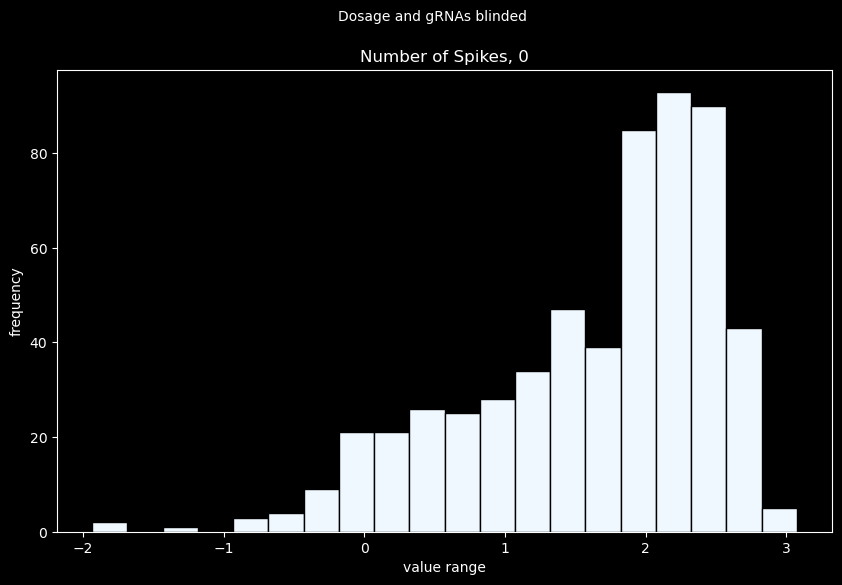

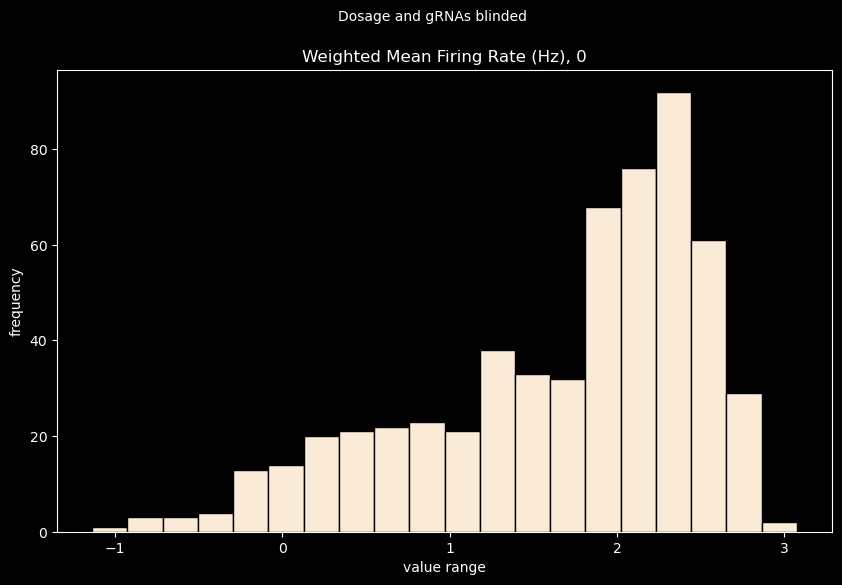

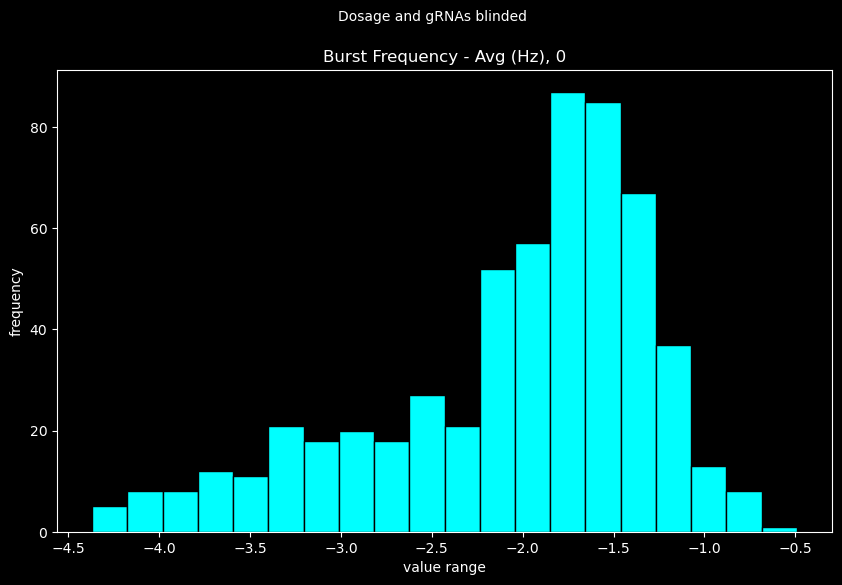

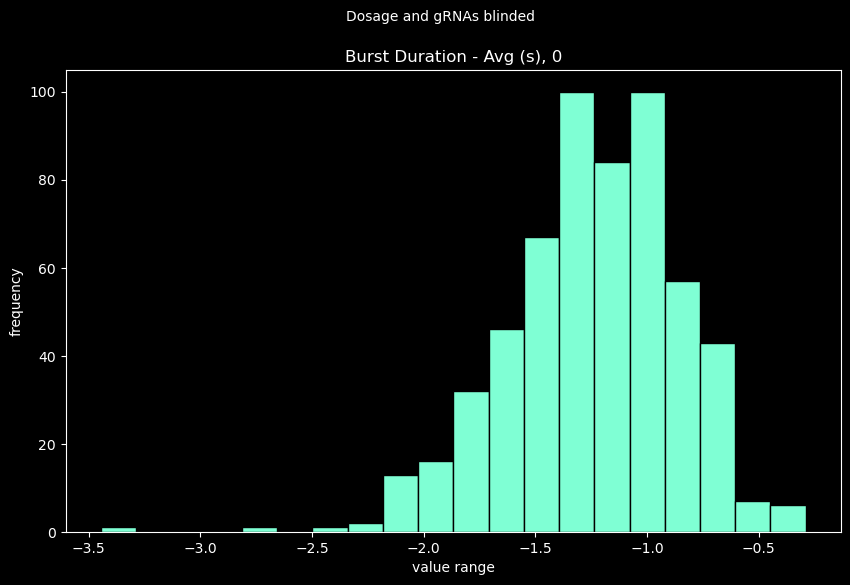

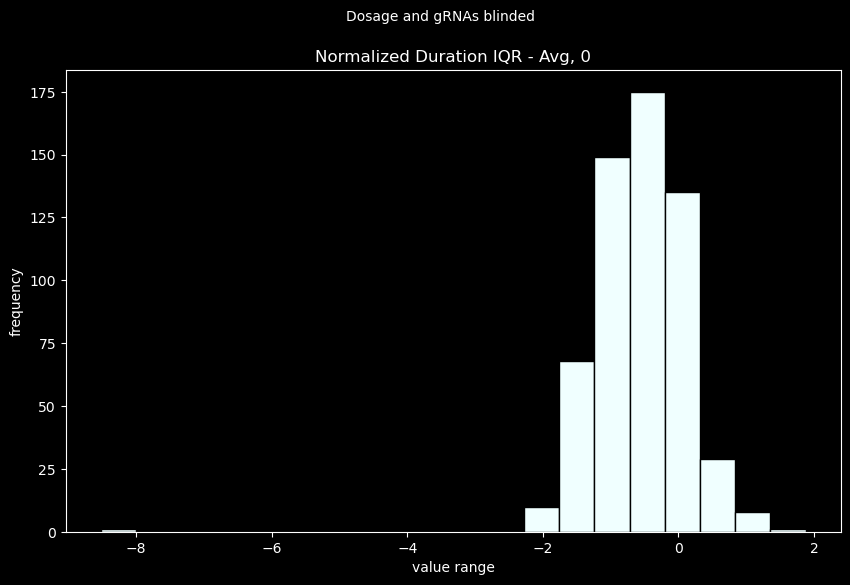

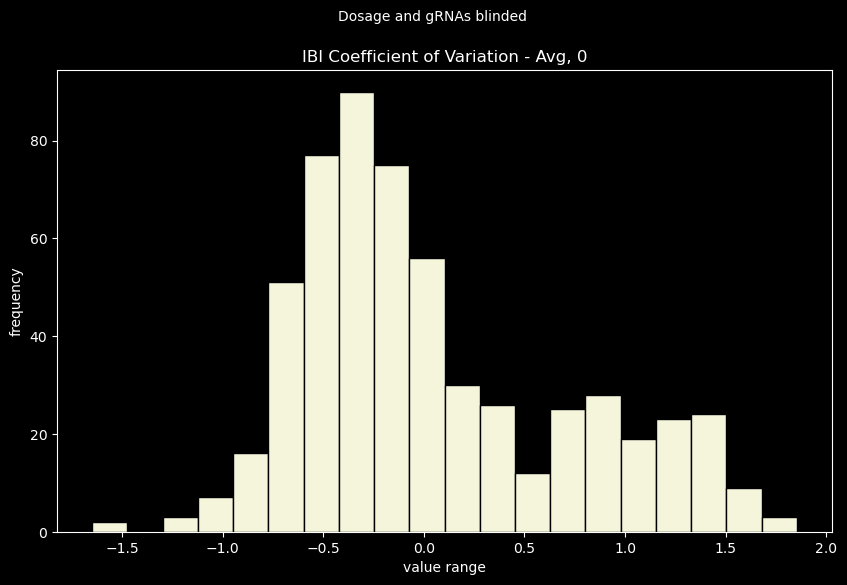

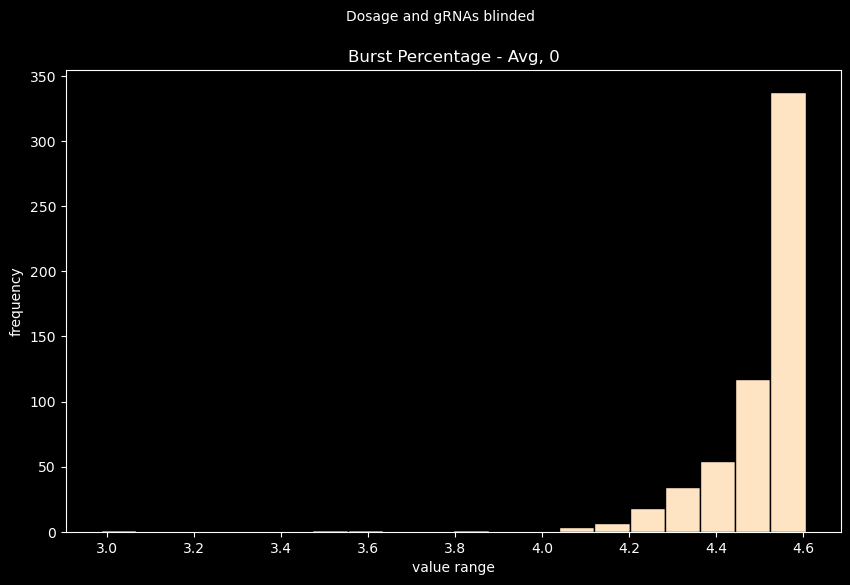

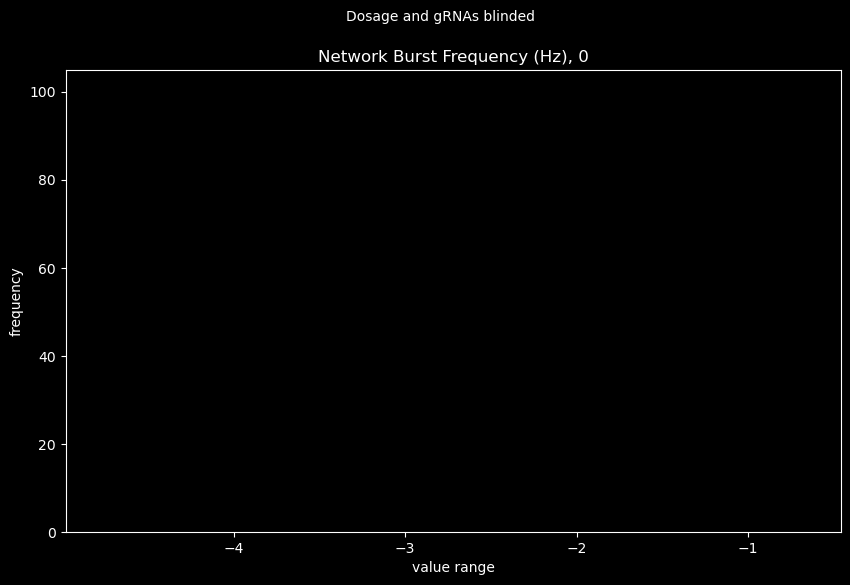

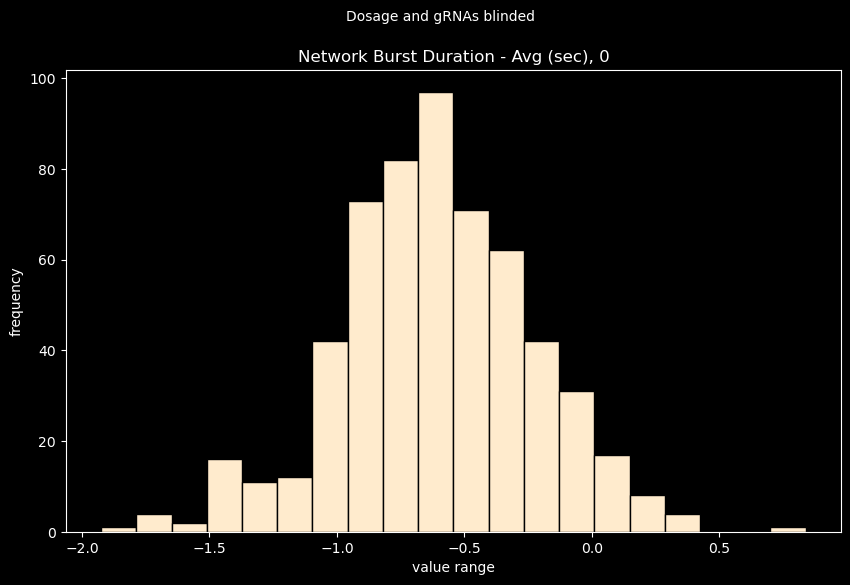

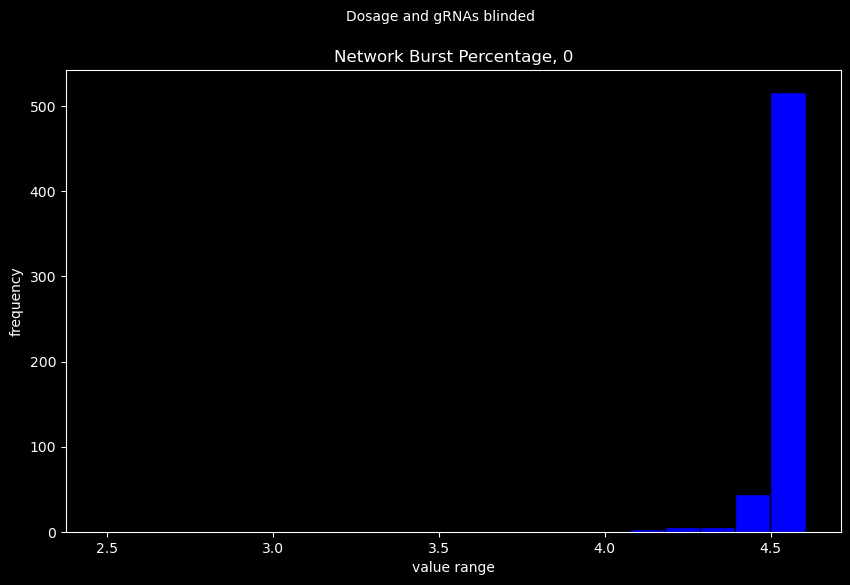

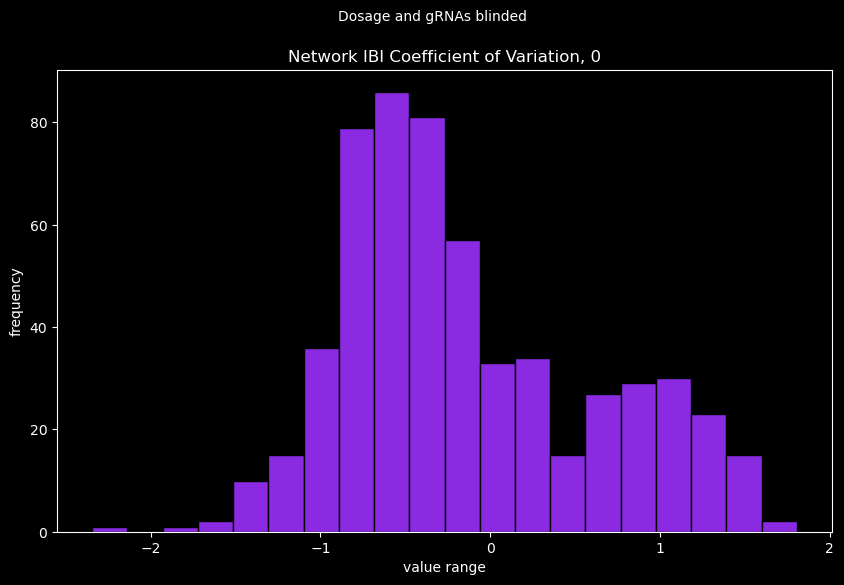

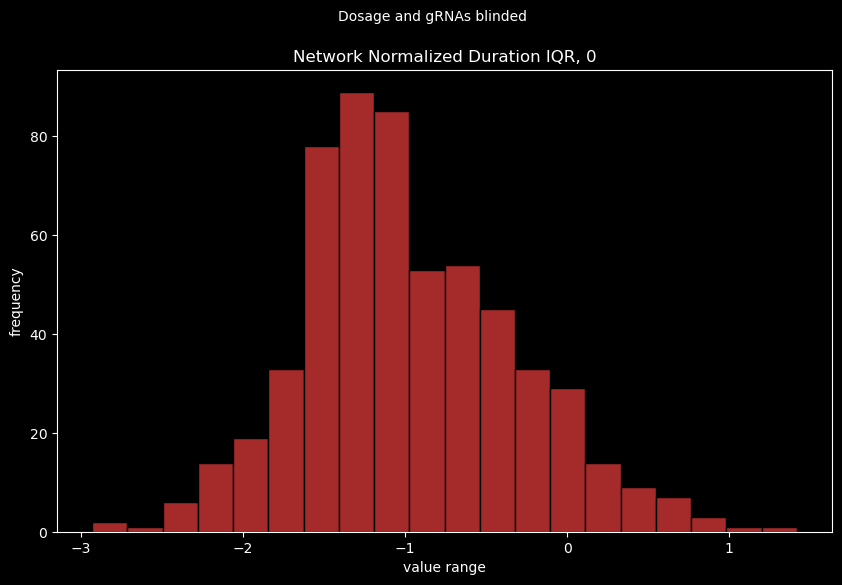

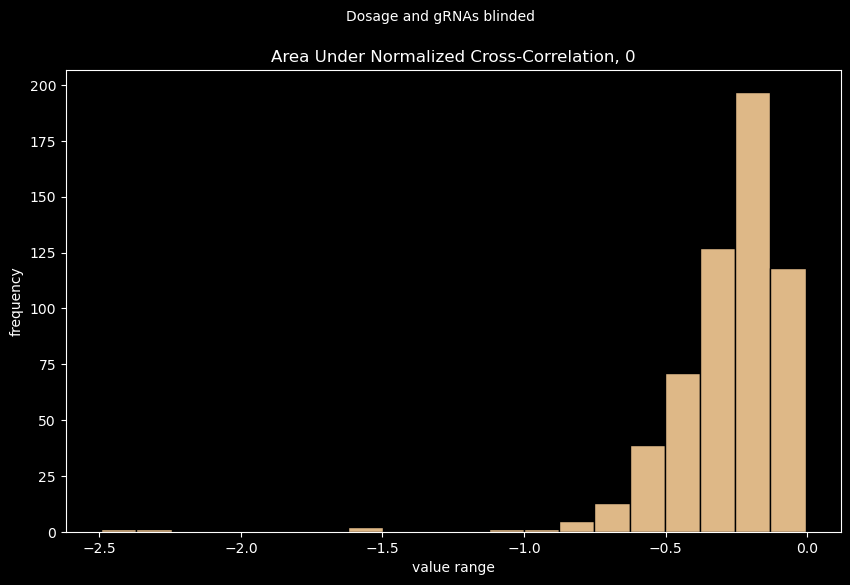

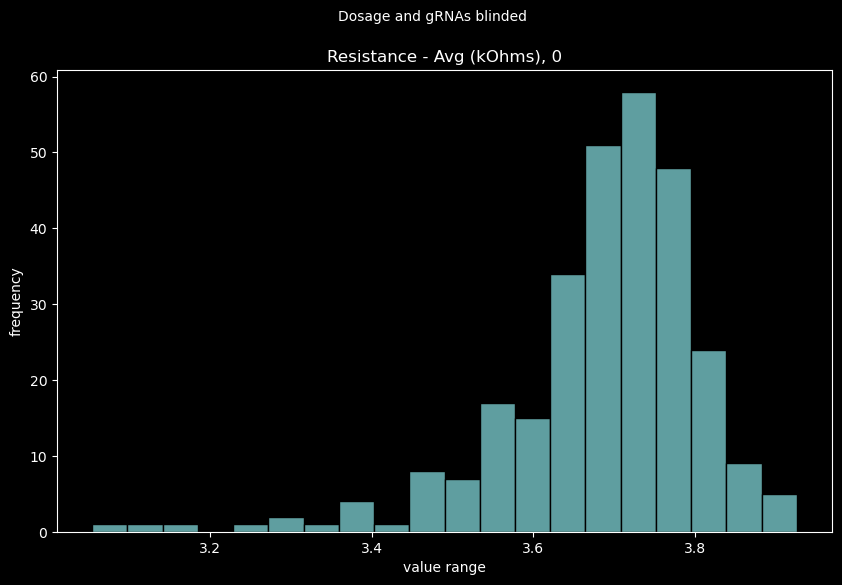

In [115]:
## lets do a quick histogram of all concentration and genes combined. each test
for i, ((test, lamb), hdata) in enumerate(log.items()):
        # if i == 0:
                plt.figure(figsize=(10, 6))  # You can adjust the figure size as needed
                # hdata = BC[test].drop(columns=['Chemical_Type'])
                # hdata = hdata.to_numpy().flatten()
                plt.hist(hdata, bins=20, color=f'{colors[i]}', edgecolor='black')
                plt.suptitle(f'Dosage and gRNAs blinded', fontsize=10)
                plt.title(f'{test}, {lamb}')
                SAVE_FILE = f'../plots/histograms/log/{os.path.basename(os.path.normpath(FOLDER_PATH))}/'\
                        f'fullblind/{test}.png'
                ensure_dirs_exists(SAVE_FILE)
                plt.xlabel('value range')
                plt.ylabel('frequency')
                plt.savefig(SAVE_FILE)
                plt.show()

In [95]:
BC[('Number of Spikes', 0.5449335202768498)]

array([ 7.13745193e-01,  1.66953828e+00,  2.73019171e+00,  1.92786396e+00,
       -1.65712037e-01,  1.56452052e+00,  1.88943580e+00,  9.39244976e-01,
       -1.00816751e-01,  3.38455582e+00, -9.15339929e-01,  7.32798136e-02,
        2.07130901e+00,  1.59532992e+00,  1.92293468e+00,  7.52360542e-01,
        3.60648268e+00,  1.32526902e+00,  3.62337542e-01,  1.03423491e+00,
        1.23770784e+00,  8.65576678e-01,  3.57500338e+00,  1.23241209e+00,
        4.56350264e-01,  1.00233476e+00,  1.47218841e-01,  2.52978008e+00,
       -6.32352931e-01,  5.68646403e-01,  2.62098653e+00,  3.72189798e+00,
        9.93186103e-01,  1.67184756e+00,  6.30120724e-01,  2.15811401e+00,
        1.65370367e+00, -3.66474374e-01,  2.45762423e+00,  1.46051467e-03,
       -1.45488678e-01,  7.46933764e-02, -1.19530689e+00,  1.46005012e+00,
        1.37150715e+00, -1.87880322e-03,  3.50970132e+00,  9.94058402e-01,
        6.34357473e-01,  2.13012326e+00,  2.49877466e-01,  1.89959257e+00,
        3.62208105e-02,  

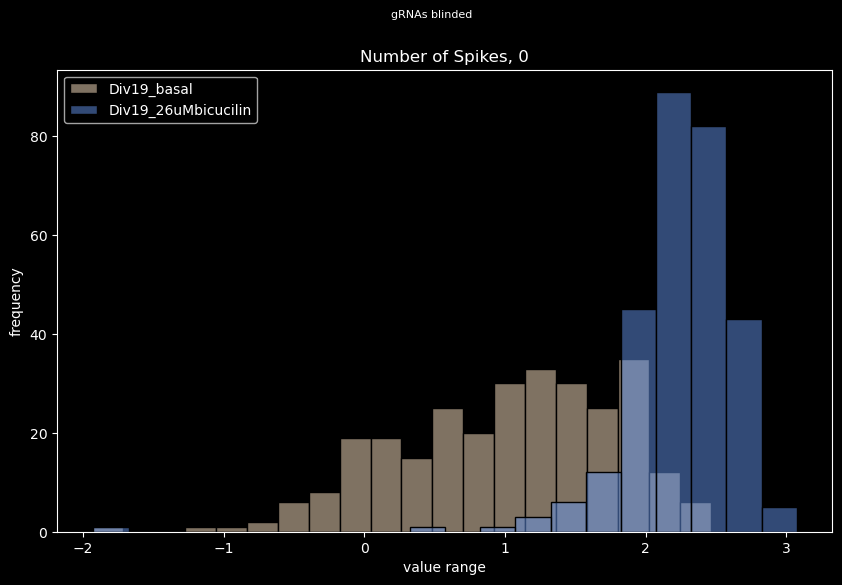

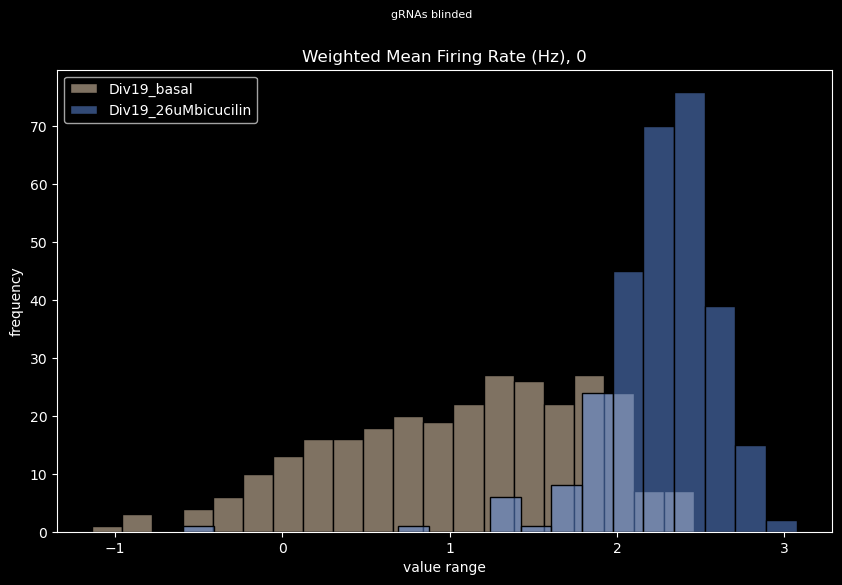

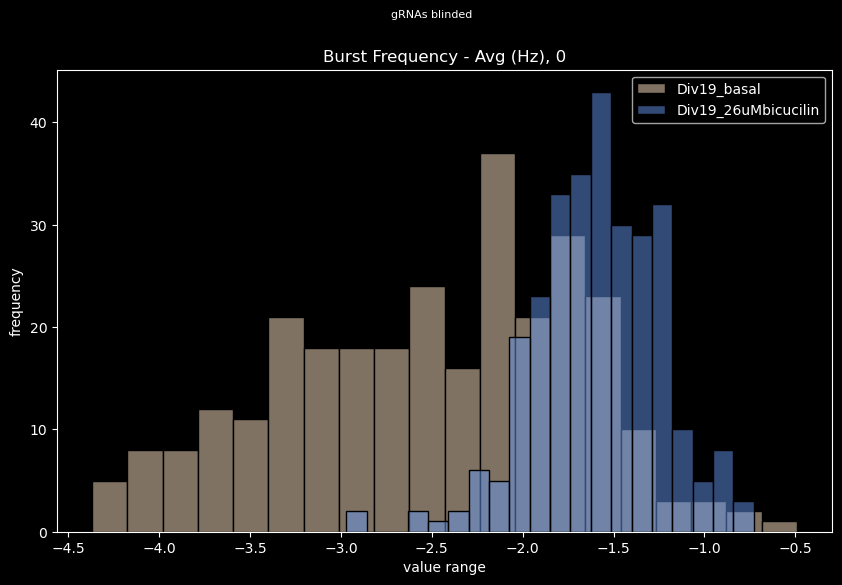

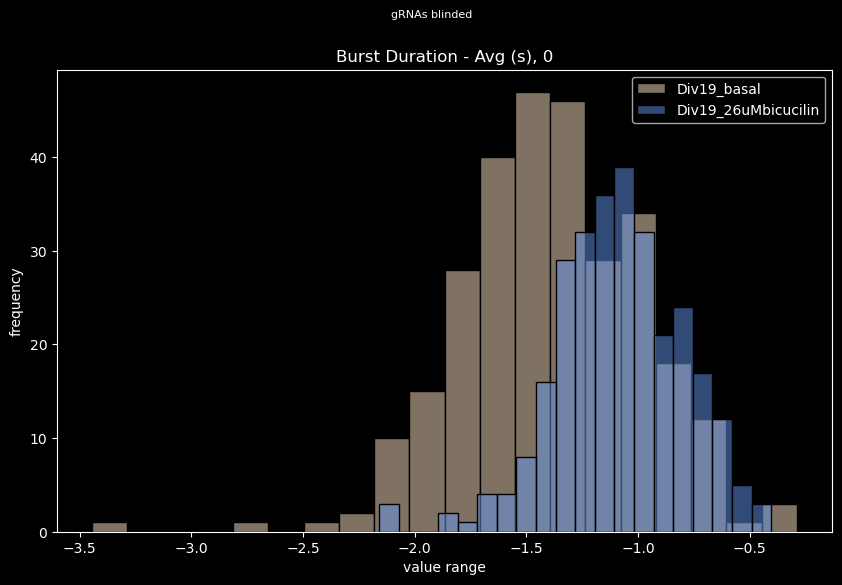

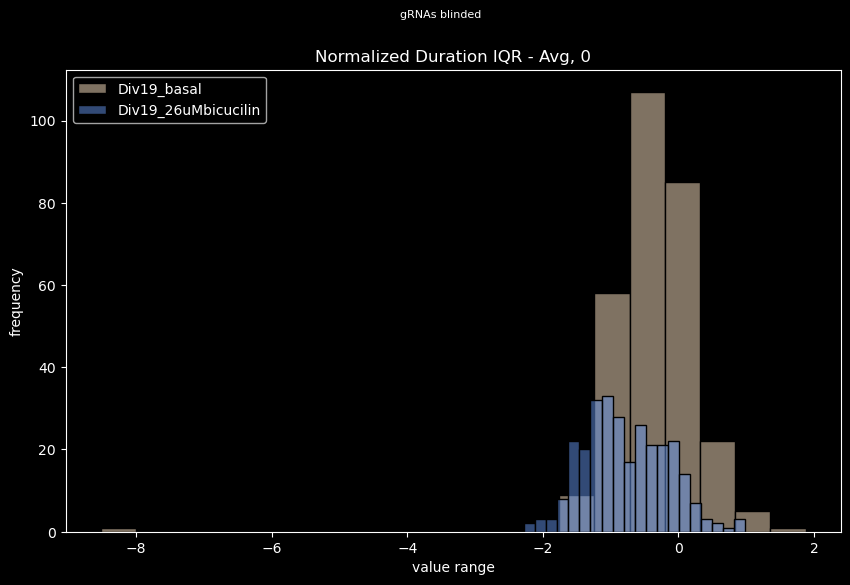

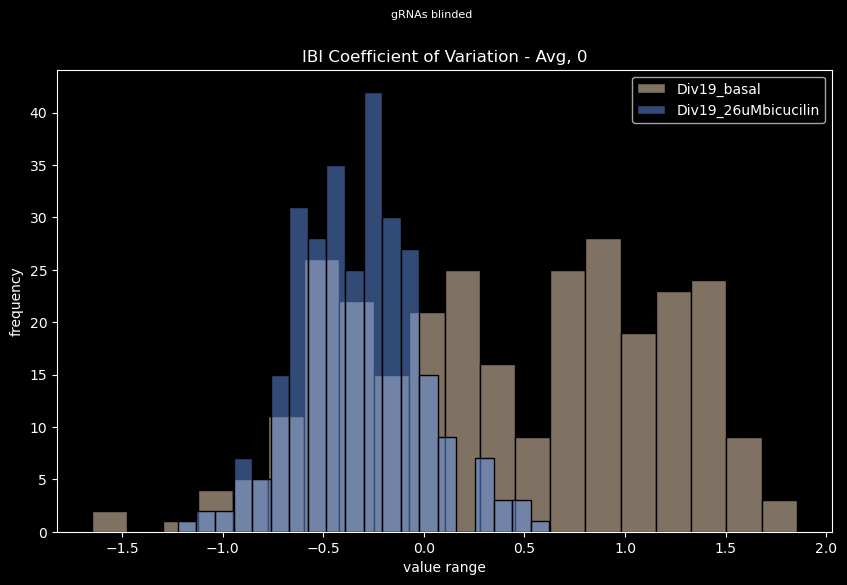

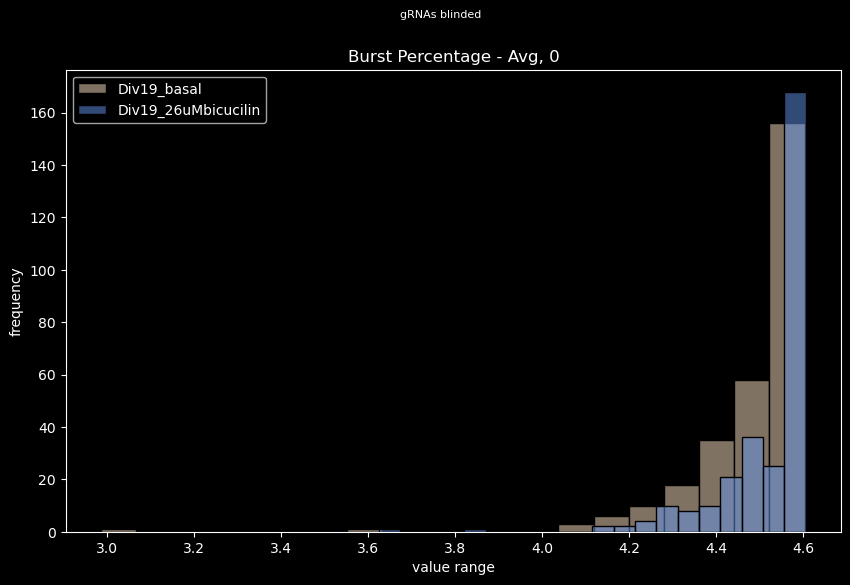

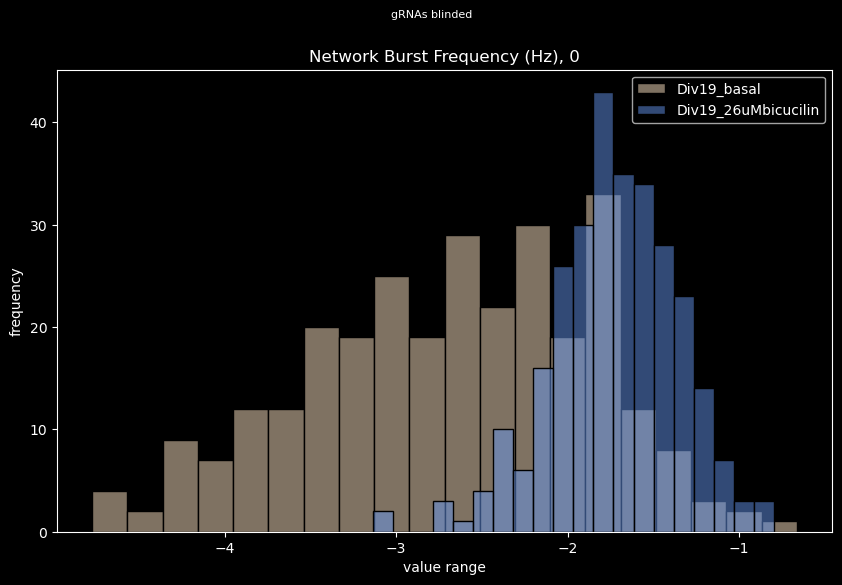

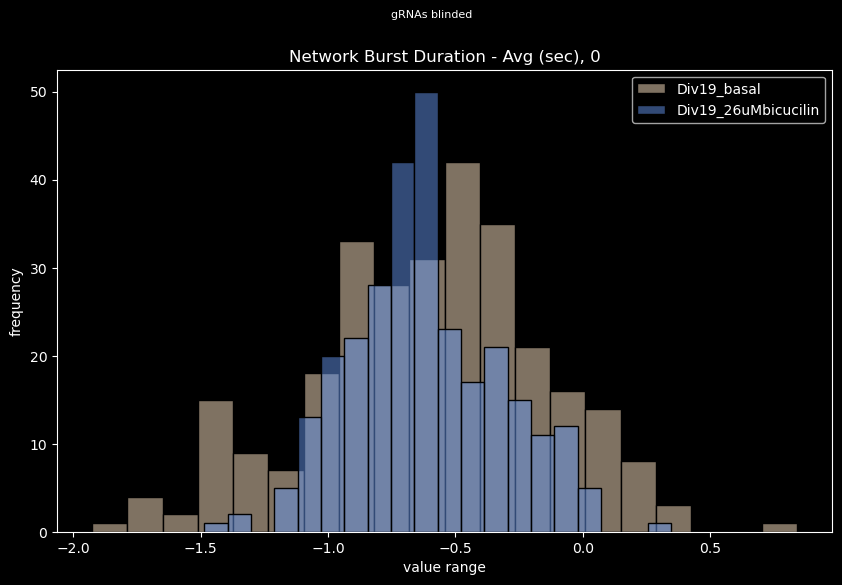

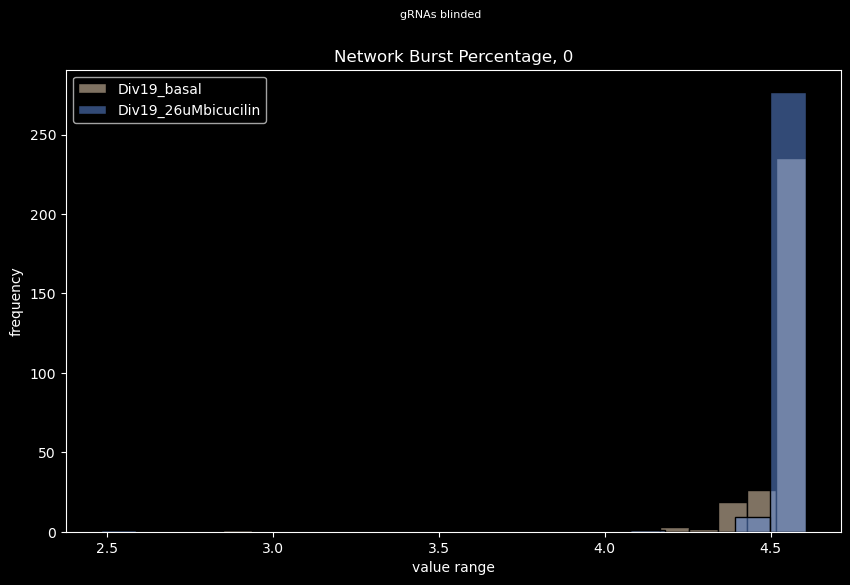

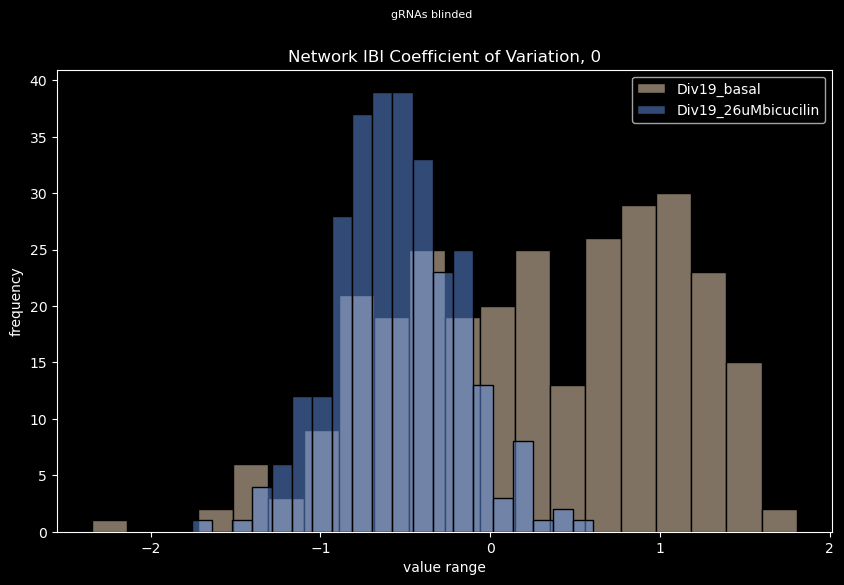

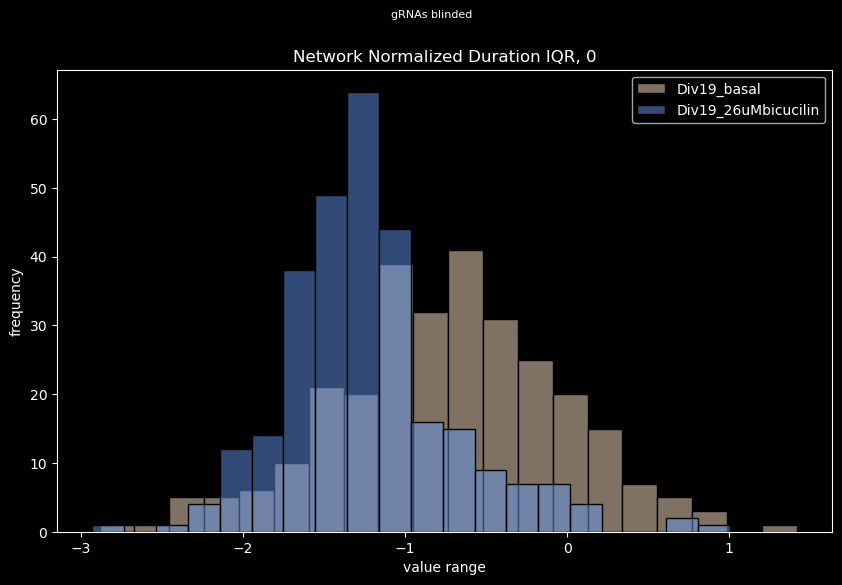

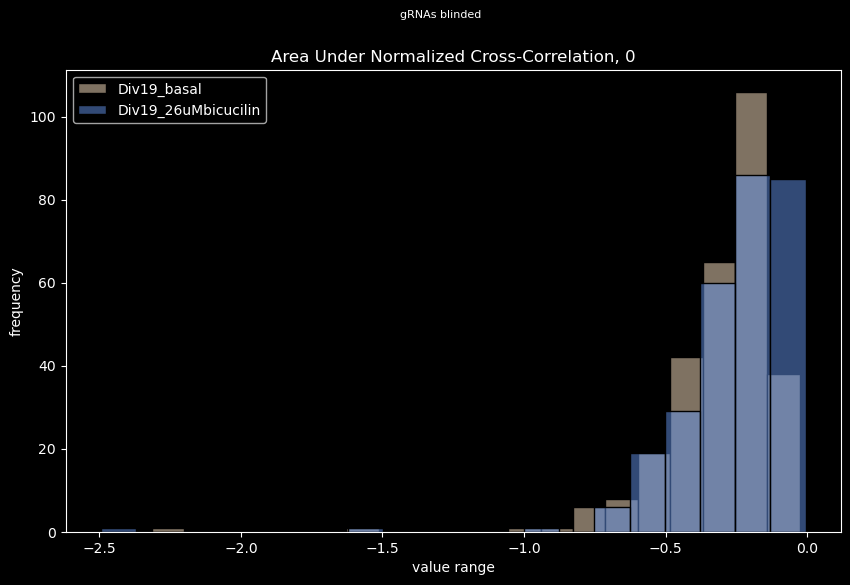

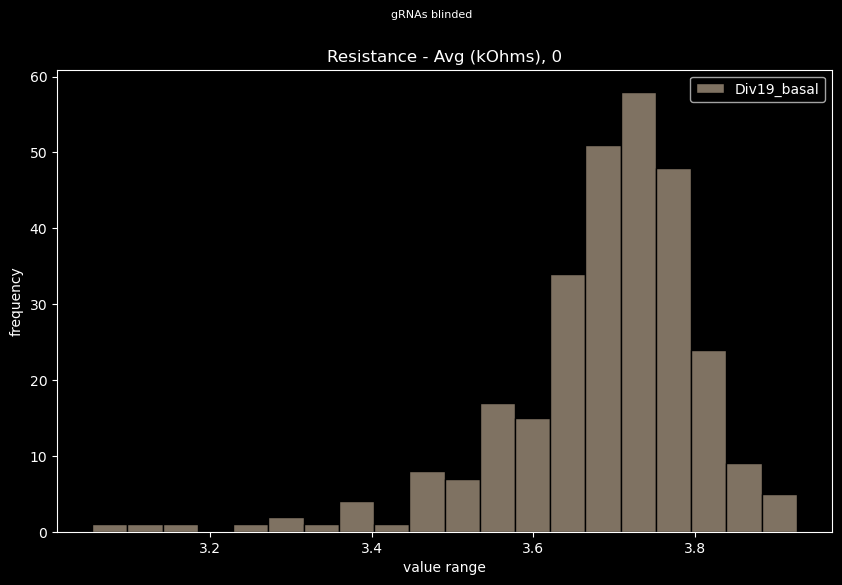

In [117]:
from matplotlib.colors import to_rgba
ncolors= list([colors[6], colors[17]])
## histogram w genes blinded.
for i, ((test, lamb), hdata) in enumerate(log.items()):
        plt.figure(figsize=(10, 6))  # You can adjust the figure size as needed
        for j, chem in enumerate(log_df[test]['Chemical_Type'].unique()):
            hdata = log_df[test][log_df[test]['Chemical_Type'] == chem]
            hdata = hdata.drop('Chemical_Type', axis=1)
            hdata = hdata.to_numpy().flatten()
            color = to_rgba(ncolors[j % len(ncolors)], alpha=0.5)
            
            # Plot histogram with label
            plt.hist(hdata, bins=20, color=color, edgecolor='black', label=chem)
        plt.suptitle(f'gRNAs blinded', fontsize=8)
        plt.title(f'{test}, {lamb}')
        plt.xlabel('value range')
        plt.ylabel('frequency')
        SAVE_FILE = f'../plots/histograms/log/{os.path.basename(os.path.normpath(FOLDER_PATH))}/'\
                    f'geneblind/{test}.png'
        ensure_dirs_exists(SAVE_FILE)
        plt.legend()
        plt.savefig(SAVE_FILE)
        plt.show()
    

In [73]:
BC

{('Number of Spikes',
  0.5449335202768498): array([ 7.13745193e-01,  1.66953828e+00,  2.73019171e+00,  1.92786396e+00,
        -1.65712037e-01,  1.56452052e+00,  1.88943580e+00,  9.39244976e-01,
        -1.00816751e-01,  3.38455582e+00, -9.15339929e-01,  7.32798136e-02,
         2.07130901e+00,  1.59532992e+00,  1.92293468e+00,  7.52360542e-01,
         3.60648268e+00,  1.32526902e+00,  3.62337542e-01,  1.03423491e+00,
         1.23770784e+00,  8.65576678e-01,  3.57500338e+00,  1.23241209e+00,
         4.56350264e-01,  1.00233476e+00,  1.47218841e-01,  2.52978008e+00,
        -6.32352931e-01,  5.68646403e-01,  2.62098653e+00,  3.72189798e+00,
         9.93186103e-01,  1.67184756e+00,  6.30120724e-01,  2.15811401e+00,
         1.65370367e+00, -3.66474374e-01,  2.45762423e+00,  1.46051467e-03,
        -1.45488678e-01,  7.46933764e-02, -1.19530689e+00,  1.46005012e+00,
         1.37150715e+00, -1.87880322e-03,  3.50970132e+00,  9.94058402e-01,
         6.34357473e-01,  2.13012326e+00,  2

<Figure size 1000x600 with 0 Axes>

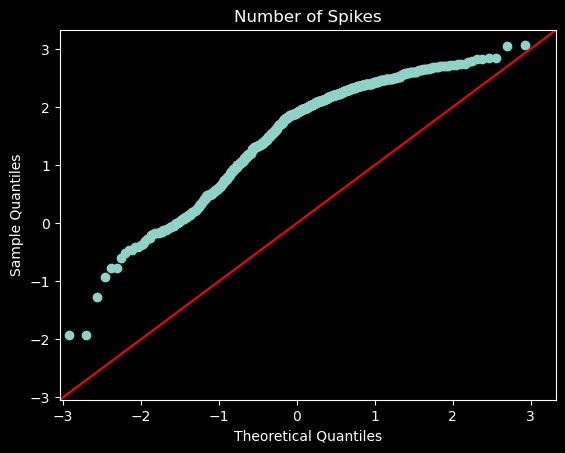

<Figure size 1000x600 with 0 Axes>

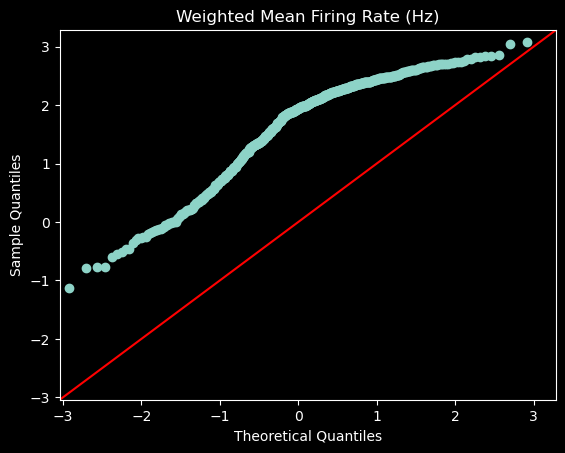

<Figure size 1000x600 with 0 Axes>

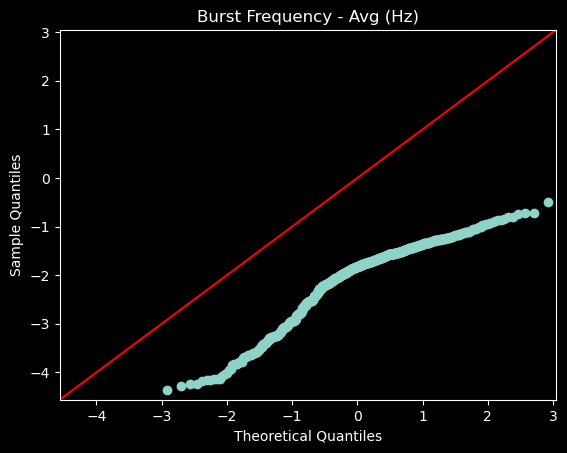

<Figure size 1000x600 with 0 Axes>

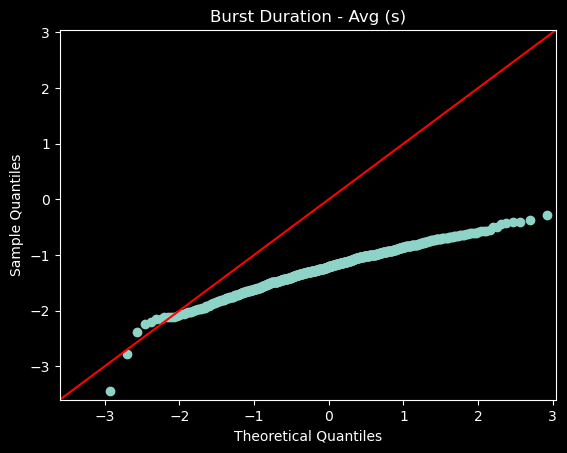

<Figure size 1000x600 with 0 Axes>

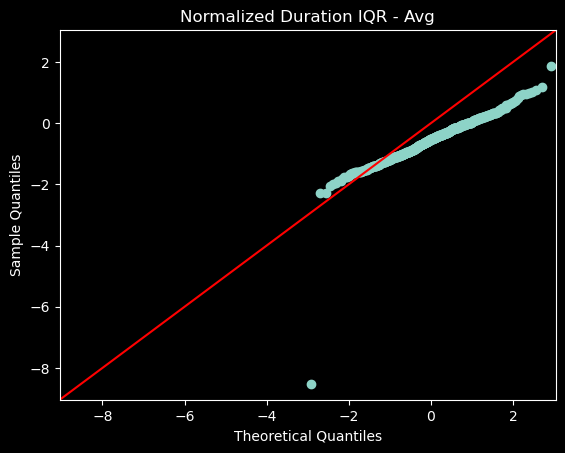

<Figure size 1000x600 with 0 Axes>

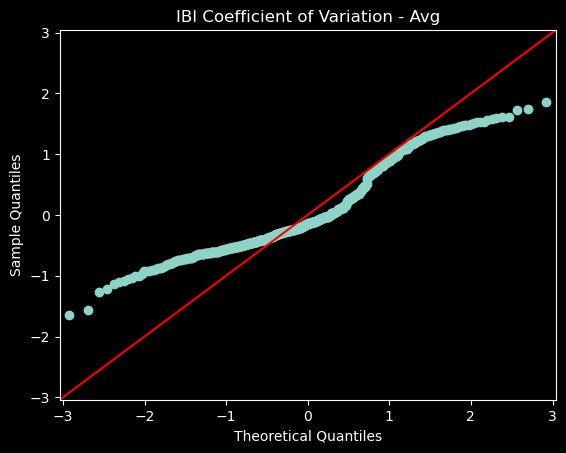

<Figure size 1000x600 with 0 Axes>

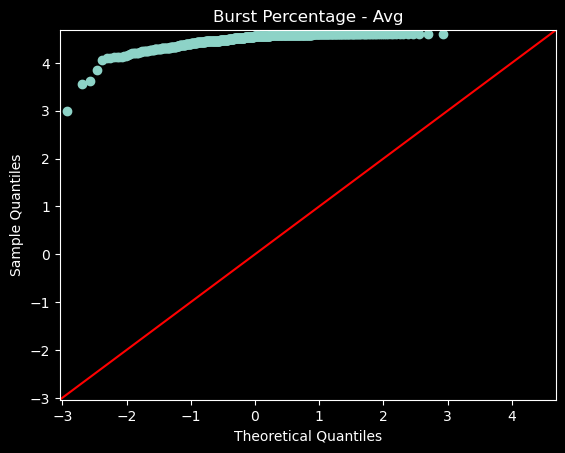

<Figure size 1000x600 with 0 Axes>

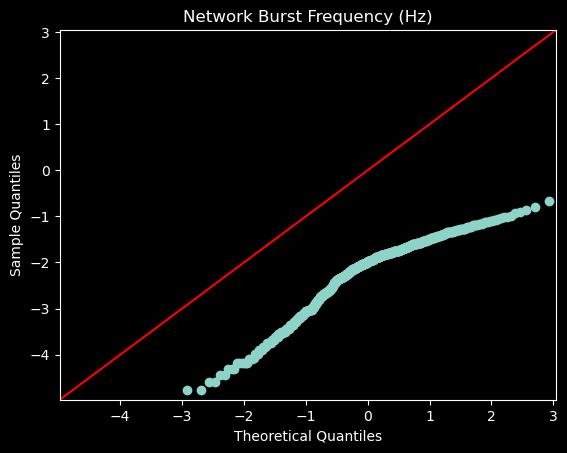

<Figure size 1000x600 with 0 Axes>

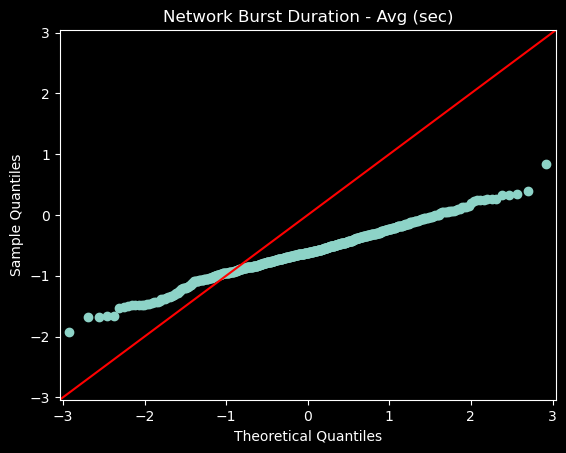

<Figure size 1000x600 with 0 Axes>

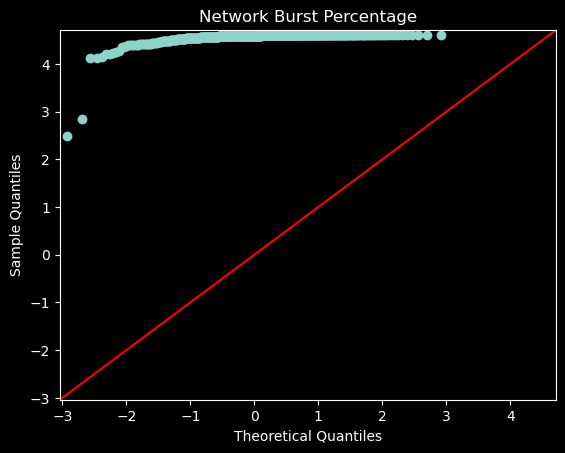

<Figure size 1000x600 with 0 Axes>

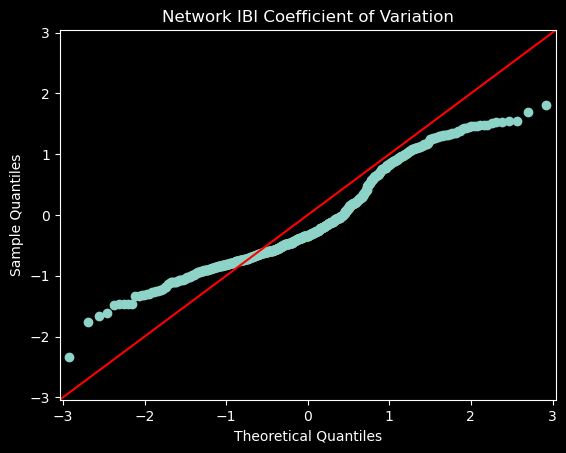

<Figure size 1000x600 with 0 Axes>

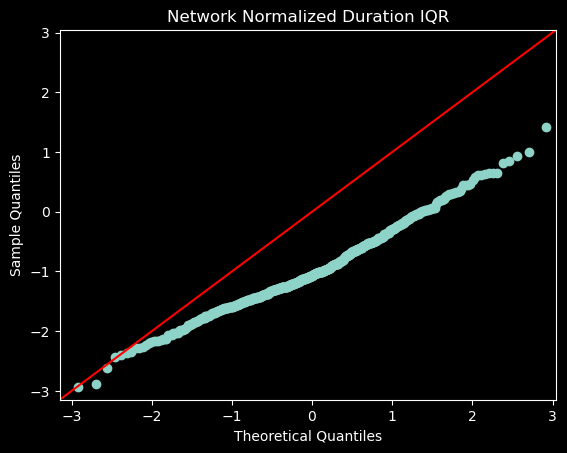

<Figure size 1000x600 with 0 Axes>

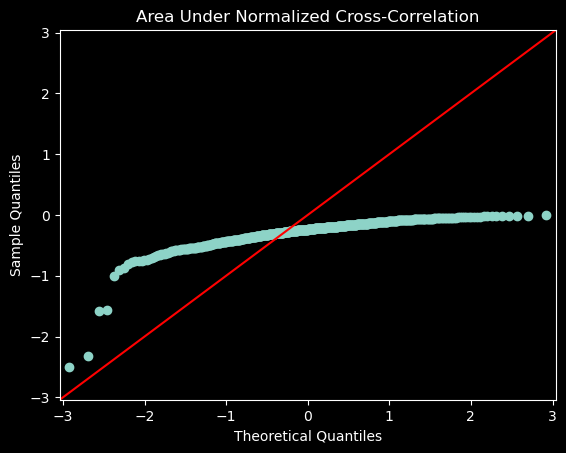

<Figure size 1000x600 with 0 Axes>

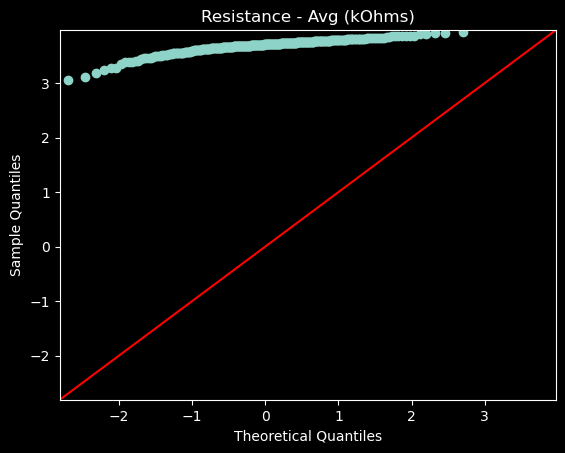

In [118]:

for i, ((test, lamb), hdata) in enumerate(log.items()):
        plt.figure(figsize=(10, 6))  # You can adjust the figure size as needed
        # hdata = hdata.drop('Chemical_Type', axis=1)
        # hdata = hdata.to_numpy().flatten()
        fig = sm.qqplot(hdata, line='45')  # '45' adds a 45-degree reference line
        plt.title(f'{test}')
        SAVE_FILE = f'../plots/qqplots/log/{os.path.basename(os.path.normpath(FOLDER_PATH))}/'\
                f'fullblind/{test}.png'
        ensure_dirs_exists(SAVE_FILE)
        plt.savefig(SAVE_FILE)
        plt.show()

Lucio mentioned looking at controls only first will be helpful. Therefore the first three types of plots are comparing two different controls with varying concentration dosages for a singular test. 

Plot types 4-6 contain all genes between concentrations 
